# Inference notebook for MD-SEM

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.notebook import tqdm
from matplotlib.image import imread
import os
import sys
sys.path.append('src/')
from multiduration_models import xception_se_lstm

## Load model ##

In [2]:
shape_r = 240
shape_c = 320
n_outs_model = 3
loaded_model = xception_se_lstm(input_shape = (shape_r,shape_c,3), n_outs = n_outs_model, ups=16, verbose=False)

load_weights = True

base_ckpt_path = 'ckpt/'

Wb = "mdsem_codecharts0_cameraready_weights.hdf5"

W =  os.path.join(base_ckpt_path, Wb)

if load_weights:
    loaded_model.load_weights(W)

xception output shapes: (None, 30, 40, 2048)
shape after AvgPool (None, 3, 2048)
shape after first dense (None, 3, 512)
shape after lstm (None, 3, 512)
shape after second dense: (None, 3, 2048)
shape before mult (None, 3, 1, 1, 2048)
shape out (None, 3, 30, 40, 2048)
Shape after last ups: (None, 3, 480, 640, 64)
Shape after 1x1 conv: (None, 3, 480, 640, 1)


## Helper functions for pre-processing images prior to evaluation ##

In [3]:
def padding(img, shape_r, shape_c, channels=3):
    img_padded = np.zeros((shape_r, shape_c, channels), dtype=np.uint8)
    if channels == 1:
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)

    original_shape = img.shape
    rows_rate = original_shape[0]/shape_r
    cols_rate = original_shape[1]/shape_c

    if rows_rate > cols_rate:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        img = cv2.resize(img, (new_cols, shape_r))
        if new_cols > shape_c:
            new_cols = shape_c
        img_padded[:, ((img_padded.shape[1] - new_cols) // 2):((img_padded.shape[1] - new_cols) // 2 + new_cols)] = img
    else:
        new_rows = (original_shape[0] * shape_c) // original_shape[1]
        img = cv2.resize(img, (shape_c, new_rows))
        if new_rows > shape_r:
            new_rows = shape_r
        img_padded[((img_padded.shape[0] - new_rows) // 2):((img_padded.shape[0] - new_rows) // 2 + new_rows), :] = img

    return img_padded

def preprocess_images(paths, shape_r, shape_c):
    ims = np.zeros((len(paths), shape_r, shape_c, 3))

    for i, path in enumerate(tqdm(paths)):
        original_image = cv2.imread(path)
        padded_image = padding(original_image, shape_r, shape_c, 3)
        ims[i] = padded_image
        ims[i,:,:,0] -= 103.939
        ims[i,:,:,1] -= 116.779
        ims[i,:,:,2] -= 123.68

    return ims


def reverse_preprocess(img):
    im = deepcopy(img)

    im[:, :, 0] += 103.939
    im[:, :, 1] += 116.779
    im[:, :, 2] += 123.68

    im = im[...,::-1]

    im = np.array(im, dtype=np.uint8)

    return im

## Evaluate loaded model on a few sample images ##

In [20]:
model_inp_size = (240, 320)
image_path = "data/images/train/"
output_path = "data/3-sliced_mdsem_preds/"

imgs = [os.path.join(image_path, f) for f in sorted(os.listdir(image_path)) if f != ".DS_Store"][5000:]
images = preprocess_images(imgs, model_inp_size[0], model_inp_size[1])

In [21]:
BATCH_SIZE = 10
times = [500, 3000, 5000]
ntimes = len(times)

for i in tqdm(range(0, len(images), BATCH_SIZE)):
    preds_mdsem = loaded_model.predict(images[i:i+BATCH_SIZE])
    
    for j in range(BATCH_SIZE):
        for t in range(ntimes):
            filename = imgs[i+j].split('/')[-1][:-3] + 'png'
            pred = preds_mdsem[0][j,t,:,:,0]
            cv2.imwrite(output_path + str(times[t]) + '/' + filename, 255 * pred / pred.max())

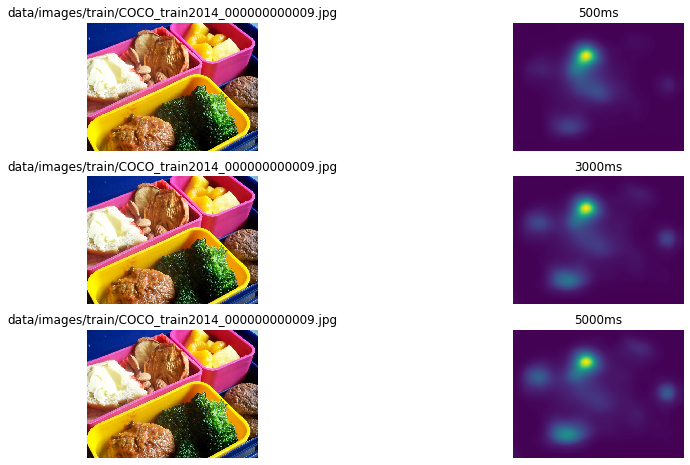

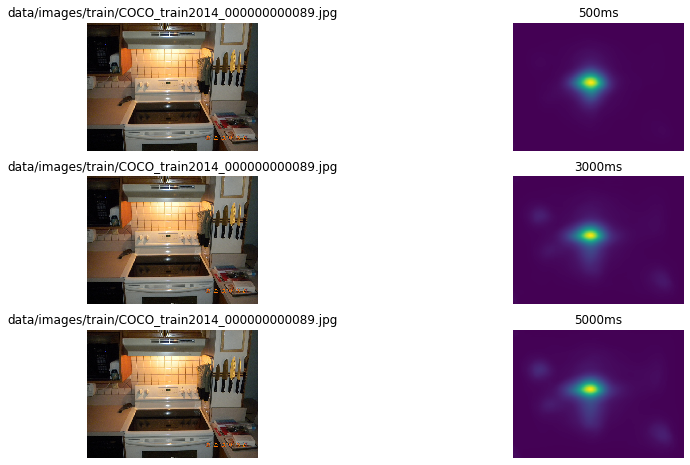

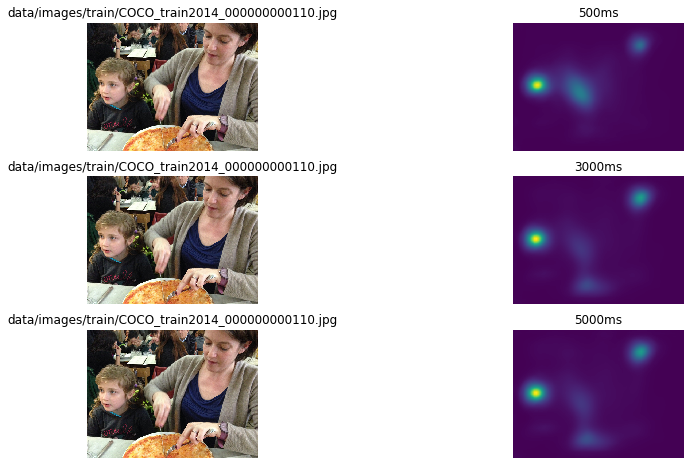

In [18]:
times = [500, 3000, 5000] 
ntimes = len(times)

for i in range(3):
    filename = imgs[i].split('/')[-1]
    plt.figure(figsize = (14,8))
    # Plot maps for each timestep
    for t in range(ntimes):
        plt.subplot(ntimes,2,t*2+1)
        plt.imshow(imread(image_path + filename))
        plt.axis('off')
        plt.title(imgs[i])
        plt.subplot(ntimes,2,t*2+2)
        plt.imshow(imread(output_path + str(times[t]) + '/' + filename[:-3] + 'png'))
        plt.axis('off')
        plt.title(str(times[t])+'ms')